## Multi-cell-line analysis
One can extend the above profiling framework to multi-cell-line MOA prediction by pooling data or ensembling models. In a pooling analysis such as Warchal et al. (2016), the cells of the respective cell lines are first normalised and then grouped across drugs to increase the amount of available data. An ensemble approach such as Rose et al. (2018) creates models for each cell line and aggregates their individual predictions. This approach has the additional advantage of allowing different imaging modalities of fluorescent markers.

We adopted a pooling approach to predict MOA from multiple cell lines. We benchmarked three multi-task autoencoders--an extension of classical autoencoders--on handcrafted features of segmented cells. The challenge of this approach is to reconcile the inherent differences between the cell lines in feature space, which derives from the fundamental morphological differences of the cell lines.

In [1]:
from __future__ import print_function
from __future__ import division

import os
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import *
from src.lococv import construct_profiles, lococv
from src.feature_reader import FeatureReader
from src.vis_utils import image_crop_training_set

from IPython.display import Image, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

Using TensorFlow backend.


In [2]:
metadata_file = 'PlateMap-KPP_MOA.xlsx'
df_metadata = pd.read_excel(metadata_file).set_index('well')

# Create drug type column
df_metadata.loc[df_metadata['content'] != 'DMSO', 'category'] = 'Perturbation'
df_metadata.loc[df_metadata['content'] == 'DMSO', 'category'] = 'DMSO'
df_metadata.loc[df_metadata['content'] == 'None', 'category'] = 'None'
df_metadata.loc[df_metadata['content'] == 'Olaparib', 'category'] = 'Positive'
df_metadata.loc[df_metadata['content'] == 'Cisplatine', 'category'] = 'Positive'

# Remove drugs
df_metadata = df_metadata.drop(df_metadata[df_metadata['moa'] == 'Wild'].index)

# Remove wells without content
df_metadata = df_metadata[~df_metadata.content.isnull()]

In [3]:
cecog_out = './cecog_out_propagate_0.5'
channels = ['primary__primary4', 'secondary__propagate', 'tertiary__expanded']

plates = {'mda231' : '22_384_20X-hNA_D_F_C3_C5_20160031_2016.01.25.17.23.13_MDA231',
          'mda468' : '22_384_20X-hNA_D_F_C3_C5_20160032_2016.01.25.16.27.22_MDA468'}

plate_data = {}

for cell_line in plates.keys():
    
    ch5_path = '%s/%s/hdf5/' % (cecog_out, plates[cell_line])

    # read handcrafted features
    fr = FeatureReader(plates[cell_line], ch5_path, channels, cell_line)
    fr.read_all()
    fr.data['cell_line'] = cell_line
    plate_data[cell_line] = fr

    problem_feature = 'primary__primary4_dyn_distance_radius_3'
    fr.data = fr.data.drop(problem_feature, axis=1)
    fr.feature_names.remove(problem_feature)

    # Join metadata
    fr.join_plate_map(df_metadata.reset_index())
    fr.data = fr.data[~fr.data['content'].isnull()]

Reading cell data...
Reading cell centers...
Reading primary__primary4 features...
Reading secondary__propagate features...
Reading tertiary__expanded features...
Removing invalid data...
Done!
Reading cell data...
Reading cell centers...
Reading primary__primary4 features...
Reading secondary__propagate features...
Reading tertiary__expanded features...
Removing invalid data...
Done!


In [4]:
df_mda231 = plate_data['mda231'].data
mda231_wells = set(df_mda231.well)

df_mda468 = plate_data['mda468'].data
mda468_wells = set(df_mda468.well)

common_wells = mda231_wells.intersection(mda468_wells)

df_pooled = pd.concat([df_mda231[df_mda231.well.isin(common_wells)],
                       df_mda468[df_mda468.well.isin(common_wells)]])

# choose dataset_index in range(60)
dataset_index = 43

# read pre-sampled wells from file
df_wells = pd.read_csv('./datasets.csv', index_col=0)
fold_wells = sorted(list(df_wells.loc[dataset_index]))

df_fold = df_pooled[df_pooled.well.isin(fold_wells)].copy()
moas = df_fold.moa.unique()

hc_features = list(filter(lambda x : x.startswith('primary') or
                                     x.startswith('secondary') or
                                     x.startswith('tertiary'), df_pooled.columns))

# normalise cell line data
x_mda231 = df_fold[df_fold.cell_line == 'mda231'][hc_features]
x_mda231 = (x_mda231 - np.mean(x_mda231, axis=0)) / np.std(x_mda231, axis=0)

x_mda468 = df_fold[df_fold.cell_line == 'mda468'][hc_features]
x_mda468 = (x_mda468 - np.mean(x_mda468, axis=0)) / np.std(x_mda468, axis=0)

df_fold[hc_features] = np.vstack([x_mda231, x_mda468])

## Multitask autoencoders for multi-cell-line analysis
Multi-task models learn to predict multiple targets simultaneously and multitask neural nets often build more generalised internal representations (Caruana, 1997). We propose multitask autoencoders as an approach to reconcile the divergent nature our two multi-cell-line data.

![](img/architectures.png)

### Shallow models (handcrafted features)

In [5]:
from sklearn.model_selection import train_test_split

batch_size = 256

x_data = df_fold[hc_features]

x_train_s = x_data[df_fold.cell_line == 'mda231'].values
x_train_t = x_data[df_fold.cell_line == 'mda468'].values

x_tr_s, x_te_s = train_test_split(x_train_s, test_size=batch_size // 2)
x_tr_t, x_te_t = train_test_split(x_train_t, test_size=batch_size // 2)

x_val = np.vstack([x_te_s, x_te_t])

#### Autoencoders

Autoencoders formulate a function $f(\mathbf{x}) = dec(enc(\mathbf{x}))$, where $enc(\cdot)$ and $dec(\cdot)$ correspond to the encoder and decoder parts of the neural network. This model can be trained with a mean square error (MSE) loss function, $\mathcal{L}(\mathbf{X} ; \boldsymbol\theta) = \frac{1}{N}\sum_{i=1}^N||\mathbf{x}_i - f(\mathbf{x}_i)||_2^2 + \lambda||\mathbf{\boldsymbol\theta}||^2_F$ for the $N$ samples in the dataset and where $\lambda$ is a tunable hyperparameter for the regularisation function. The hidden representation (tuned to $M=100$) corresponds to the output of the encoder, that is, the central layer of the neural network, i.e. our dimensionality reduced sample is $\mathbf{z}_i = enc(\mathbf{x}_i)$.

In [6]:
from keras.callbacks import ModelCheckpoint
from src.models import autoencoder

nb_hidden = 100
nb_features = x_data.shape[1]
model, encoder = autoencoder(input_dim=nb_features, dim_encoder=nb_hidden)

model_checkpoint = ModelCheckpoint('./ae.h5',
                                   monitor='val_loss',
                                   save_best_only=True)

train_gen = balanced_generator(x_train_s, x_train_t)

model.fit_generator(train_gen,
                    validation_data=(x_val, x_val),
                    steps_per_epoch=100,
                    epochs=30, verbose=True,
                    callbacks=[model_checkpoint])

Epoch 1/30
100/100 [==============================] - 1s 12ms/step - loss: 0.7525 - val_loss: 0.5424
Epoch 2/30
100/100 [==============================] - 1s 10ms/step - loss: 0.4405 - val_loss: 0.4473
Epoch 3/30
100/100 [==============================] - 1s 9ms/step - loss: 0.3783 - val_loss: 0.3987
Epoch 4/30
100/100 [==============================] - 1s 7ms/step - loss: 0.3591 - val_loss: 0.3642
Epoch 5/30
100/100 [==============================] - 1s 10ms/step - loss: 0.3376 - val_loss: 0.3272
Epoch 6/30
100/100 [==============================] - 1s 8ms/step - loss: 0.3538 - val_loss: 0.3156
Epoch 7/30
100/100 [==============================] - 2s 17ms/step - loss: 0.2990 - val_loss: 0.3078
Epoch 8/30
100/100 [==============================] - 2s 18ms/step - loss: 0.2886 - val_loss: 0.3001
Epoch 9/30
100/100 [==============================] - 2s 17ms/step - loss: 0.2966 - val_loss: 0.2887
Epoch 10/30
100/100 [==============================] - 2s 17ms/step - loss: 0.2711 - val_loss:

In [7]:
model.load_weights('./ae.h5')

encodings = encoder.predict(x_data, verbose=True)
encoding_names = ['a%d' % i for i in range(nb_hidden)]
df_encoding = pd.DataFrame(encodings, index=df_fold.index, columns=encoding_names)

18862/18862 [==============================] - 1s 51us/step


In [8]:
df_profiles_ae = construct_profiles(df_fold.join(df_encoding), encoding_names, 'adams')
_, confusion = lococv(df_profiles_ae, df_metadata, moas)
ae_acc = np.trace(confusion) / np.sum(confusion)
print('Accuracy: %.04f' % ae_acc)

Accuracy: 0.4250


#### Multitask Autoencoders
One obvious design is to have separate decoders for each cell line with a shared encoder. During training, minibatches will be split after the shared layers and samples routed to a decoder according to their domain. We thus minimise $\mathcal{L}_{MTA}(\mathbf{X} ; \boldsymbol\theta) = \sum_{i : d_i = 0}||\mathbf{x}_i - dec_s(enc(\mathbf{x}_i))||_2^2 + \sum_{i : d_i = 1}||\mathbf{x}_i - dec_t(enc(\mathbf{x}_i))||_2^2$, where $d_i$ identifies the domain of $\mathbf{x}_i$.

In [9]:
from keras.utils import to_categorical

batch_size = 256
nb_hidden = 200

# x_data = df_fold[hc_features]
# x_data = (x_data - np.mean(x_data, axis=0)) / (np.std(x_data, axis=0) + 1e-5)
x_source = x_data[df_fold.cell_line == 'mda231'].values
x_target = x_data[df_fold.cell_line == 'mda468'].values

x_tr_s, x_te_s = train_test_split(x_source, test_size=batch_size // 2)
x_tr_t, x_te_t = train_test_split(x_target, test_size=batch_size // 2)

x_val = np.vstack([x_te_s, x_te_t])
d_val = to_categorical(np.hstack([np.zeros(batch_size // 2),
                                  np.ones(batch_size // 2)]))

In [10]:
from src.models import multitask_autoencoder

model, encoder = multitask_autoencoder(x_train_s.shape[1], nb_hidden)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 516)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 516)          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 200)          103400      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
source (Dense)                  (None, 516)          103716      dense_3[0][0]                    
__________

In [11]:
from src.utils import multi_io_generator
train_gen = multi_io_generator(x_train_s, x_train_t)

model_checkpoint = ModelCheckpoint('./mtae.h5',
                                   monitor='val_loss',
                                   save_best_only=True)

model.fit_generator(train_gen, steps_per_epoch=100, epochs=30,
                    validation_data=([x_te_s, x_te_t], [x_te_s, x_te_t]),
                    verbose=True, callbacks=[model_checkpoint])

Epoch 1/30
100/100 [==============================] - 1s 14ms/step - loss: 1.5472 - source_loss: 0.4578 - target_loss: 0.4778 - val_loss: 1.0697 - val_source_loss: 0.4727 - val_target_loss: 0.1868
Epoch 2/30
100/100 [==============================] - 1s 11ms/step - loss: 0.7774 - source_loss: 0.2449 - target_loss: 0.2311 - val_loss: 0.7233 - val_source_loss: 0.3570 - val_target_loss: 0.1369
Epoch 3/30
100/100 [==============================] - 1s 9ms/step - loss: 0.6134 - source_loss: 0.2005 - target_loss: 0.2144 - val_loss: 0.6226 - val_source_loss: 0.3222 - val_target_loss: 0.1215
Epoch 4/30
100/100 [==============================] - 1s 9ms/step - loss: 0.5355 - source_loss: 0.1914 - target_loss: 0.1728 - val_loss: 0.5955 - val_source_loss: 0.3179 - val_target_loss: 0.1130
Epoch 5/30
100/100 [==============================] - 2s 16ms/step - loss: 0.5078 - source_loss: 0.1748 - target_loss: 0.1703 - val_loss: 0.5689 - val_source_loss: 0.3007 - val_target_loss: 0.1072
Epoch 6/30
100/10

In [12]:
model.load_weights('./mtae.h5')

encodings = encoder.predict(x_data, verbose=True)

dim_encoding = np.prod(encoder.output_shape[1:])

encoding_names = ['c%d' % i for i in range(dim_encoding)]

df_encoding = pd.DataFrame(encodings, index=df_fold.index, columns=encoding_names)

18862/18862 [==============================] - 0s 24us/step


In [13]:
df_profiles_mtae = construct_profiles(df_fold.join(df_encoding), encoding_names, 'adams')
_, confusion = lococv(df_profiles_mtae, df_metadata, moas)
mta_acc = np.trace(confusion) / np.sum(confusion)
print('Accuracy: %.04f' % mta_acc)

Accuracy: 0.4500


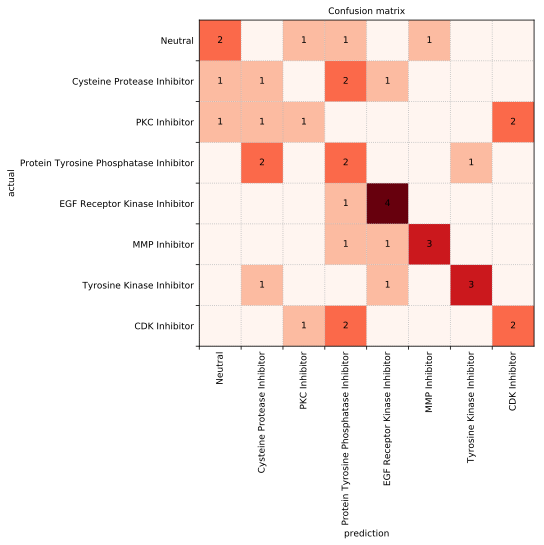

In [14]:
from src.vis_utils import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(ax, confusion, moas)

##### Domain adversarial autoencoder

Due to the fundamental morphological differences between the cell lines, we observe divergence in their distributions in feature space. The effect of these differences can be attenuated by the use of domain adaptation. Ajakan et al. (2014) proposed multi-task classifiers involving a domain discriminator trained against a classifier adversarially. As the classifier was trained to minimise one loss, the competing domain discriminator was trained to maximise another loss, such that data from either domain could not be distinguished, promoting *domain-invariant features* in the earlier, shared layers of the network. Here we propose it as a dynamic regulariser for an autoencoder, hence a domain-adversarial autoencoder (DAA), to promote better generalisation and domain-invariant representations between the cell lines. This consists of attaching a domain discriminator $g(\mathbf{x})$ to the encoding layer. For example, with a single additional layer $g(\mathbf{x}) = \mathcal{S}(\mathbf{W}_denc(\mathbf{x}) + \mathbf{b}_d)$ where $\mathcal{S}$ is the softmax function. The loss function then becomes, $$\mathcal{L}_{DAA}(\mathbf{X}, \mathbf{d} ; \boldsymbol\theta) = \frac{1}{N}\sum_{i=1}^N||\mathbf{x}_i - f(\mathbf{x}_i)||_2^2 - \frac{\omega}{N}\sum_{i=1}^N d_ig(\mathbf{x}_i) - \log[1 + \exp(g(\mathbf{x}_i))],$$ that is, the difference of a mean square error (MSE) loss and a log loss, where $f(\mathbf{x})$ is defined as before, and $\omega$ is a modulating hyperparameter. However, now the parameters of $g(\mathbf{x})$ are updated to *maximise* $\mathcal{L}_{DAA}$, thus improving the quality of domain discrimination. At the same time, the parameters of $f(\mathbf{x})$ are updated to *minimise* $\mathcal{L}_{DAA}$. This has the dual effect of minimising the MSE (as usual) but also maximising the log loss. This is known as an adversarial step, and aims at converging to a saddle point between the two objectives. In practice, this is implemented with a *gradient reversal* pseudo-layer (Ganin et al., 2016), which can easily be programmed in standard deep learning frameworks.

In [15]:
from keras.utils import to_categorical

batch_size = 256

x_data = df_fold[hc_features]
x_data = (x_data - np.mean(x_data, axis=0)) / (np.std(x_data, axis=0) + 1e-5)
x_source = x_data[df_fold.cell_line == 'mda231'].values
x_target = x_data[df_fold.cell_line == 'mda468'].values

x_tr_s, x_te_s = train_test_split(x_source, test_size=batch_size // 2)
x_tr_t, x_te_t = train_test_split(x_target, test_size=batch_size // 2)

x_val = np.vstack([x_te_s, x_te_t])
d_val = to_categorical(np.hstack([np.zeros(batch_size // 2),
                                  np.ones(batch_size // 2)]))

In [16]:
from src.models import domain_adversarial_autoencoder

nb_domains = 2
nb_hidden = 125
input_dim = x_source.shape[1]

model, encoder = domain_adversarial_autoencoder(input_dim, nb_domains, nb_hidden, lam=1.5, l=1e-3)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 516)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 125)          64625       input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 125)          500         dense_4[0][0]                    
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 125)          0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
gradient_r

In [17]:
nb_epochs = 30
train_gen = daae_generator(x_tr_s, x_tr_t, batch_size)

model_checkpoint = ModelCheckpoint('daa_weights.h5',
                                   save_best_only=True,
                                   monitor='val_main_loss',
                                   mode='min')

hist = model.fit_generator(train_gen, steps_per_epoch=100, epochs=nb_epochs,
                           validation_data=(x_val, [x_val, d_val]),
                           callbacks=[model_checkpoint], verbose=True)

Epoch 1/30
100/100 [==============================] - 2s 21ms/step - loss: 3.8492 - main_loss: 0.6152 - aux_loss: 1.9474 - val_loss: 2.2657 - val_main_loss: 0.5267 - val_aux_loss: 0.9987
Epoch 2/30
100/100 [==============================] - 1s 13ms/step - loss: 1.7105 - main_loss: 0.3304 - aux_loss: 0.7934 - val_loss: 1.6157 - val_main_loss: 0.4219 - val_aux_loss: 0.6966
Epoch 3/30
100/100 [==============================] - 1s 11ms/step - loss: 1.4463 - main_loss: 0.2737 - aux_loss: 0.6963 - val_loss: 1.5458 - val_main_loss: 0.3944 - val_aux_loss: 0.6917
Epoch 4/30
100/100 [==============================] - 1s 11ms/step - loss: 1.3782 - main_loss: 0.2287 - aux_loss: 0.6960 - val_loss: 1.4823 - val_main_loss: 0.3344 - val_aux_loss: 0.6995
Epoch 5/30
100/100 [==============================] - 1s 12ms/step - loss: 1.3644 - main_loss: 0.2244 - aux_loss: 0.6962 - val_loss: 1.4214 - val_main_loss: 0.2912 - val_aux_loss: 0.6912
Epoch 6/30
100/100 [==============================] - 1s 13ms/ste

In [18]:
model.load_weights('./daa_weights.h5')

encodings = encoder.predict(x_data, verbose=True)

dim_encoding = np.prod(encoder.output_shape[1:])
encoding_names = ['e%d' % i for i in range(dim_encoding)]

df_encoding = pd.DataFrame(encodings, index=df_fold.index, columns=encoding_names)

18862/18862 [==============================] - 1s 53us/step


In [19]:
df_profiles_daae = construct_profiles(df_fold.join(df_encoding), encoding_names, 'adams')
_, confusion = lococv(df_profiles_daae, df_metadata, moas)
dae_acc = np.trace(confusion) / np.sum(confusion)
print('Accuracy: %.04f' % dae_acc)

Accuracy: 0.5000


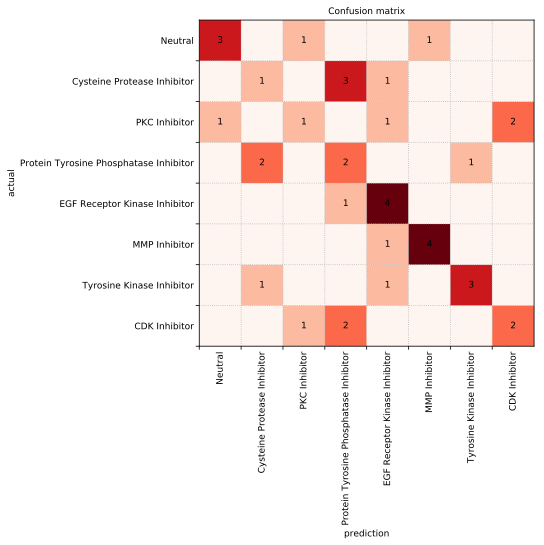

In [20]:
from src.vis_utils import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(ax, confusion, moas)

### Deep models

In [20]:
from src.vis_utils import image_crop_training_set

cell_line = 'mda231'
ch5_path = '%s/%s/hdf5/' % (cecog_out, plates[cell_line])

df = df_fold[df_fold.cell_line == 'mda231']

x_img_mda231 = image_crop_training_set(df, ch5_path, 50, 0.4)

print(x_img_mda231.shape)
print('%.02f Mb' % (sys.getsizeof(x_img_mda231) / float(10 ** 6)))

(11313, 40, 40, 3)
434.42 Mb


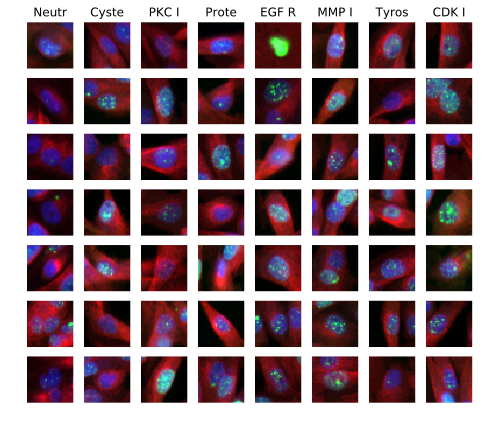

In [21]:
from src.vis_utils import plot_moa_samples

plot_moa_samples(x_img_mda231, df, moas)

In [22]:
cell_line = 'mda468'
ch5_path = '%s/%s/hdf5/' % (cecog_out, plates[cell_line])

df = df_fold[df_fold.cell_line == 'mda468']

x_img_mda468 = image_crop_training_set(df, ch5_path, 50, 0.4)
print(x_img_mda468.shape)
print('%.02f Mb' % (sys.getsizeof(x_img_mda468) / float(10 ** 6)))

(7549, 40, 40, 3)
289.88 Mb


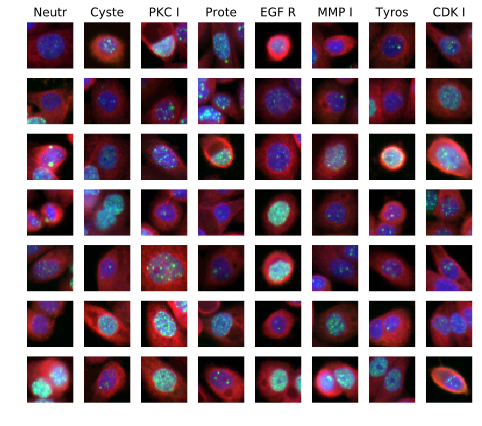

In [23]:
plot_moa_samples(x_img_mda468, df, moas)

In [24]:
batch_size = 128

x_source = (x_img_mda231 - np.mean(x_img_mda231, axis=0)) / np.std(x_img_mda231, axis=0)
x_target = (x_img_mda468 - np.mean(x_img_mda231, axis=0)) / np.std(x_img_mda231, axis=0)

x_img = np.vstack([x_source, x_target])

x_tr_s, x_te_s = train_test_split(x_source, test_size=batch_size // 2)
x_tr_t, x_te_t = train_test_split(x_target, test_size=batch_size // 2)

x_val = np.vstack([x_te_s, x_te_t])
d_val = to_categorical(np.hstack([np.zeros(batch_size // 2),
                                  np.ones(batch_size // 2)]))

#### Convolutional autoencoder

We also train deep convolutional autoencoders directly on image pixels. Note that such models perform both feature extraction and dimensionality reduction simultaneously. Here, the encoder consists of $5 \times 5$ and $3 \times 3$ convolutional layers, with $16$ and $8$ kernels respectively, and a fully connected layer ($M = 128$), each alternating with max pooling layers. The decoder mirrors this, albeit replacing pooling with upsampling.

In [25]:
from src.models import conv_autoencoder

model, encoder = conv_autoencoder()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 40, 40, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 16)        1216      
_________________________________________________________________
batch_normalization_3 (Batch (None, 40, 40, 16)        64        
_________________________________________________________________
activation_3 (Activation)    (None, 40, 40, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 8)         1160      
_________________________________________________________________
batch_normalization_4 (Batch (None, 20, 20, 8)         32        
__________

In [26]:
from keras.callbacks import ModelCheckpoint

nb_epochs = 5
train_gen = balanced_generator(x_tr_s, x_tr_t, batch_size)

model_checkpoint = ModelCheckpoint('cae_weights.h5',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min')

hist = model.fit_generator(train_gen, steps_per_epoch=100, epochs=nb_epochs,
                           validation_data=(x_val, x_val),
                           callbacks=[model_checkpoint], verbose=True)

Epoch 1/5
100/100 [==============================] - 75s 745ms/step - loss: 1.8421 - val_loss: 1.0145
Epoch 2/5
100/100 [==============================] - 70s 701ms/step - loss: 0.5641 - val_loss: 0.8667
Epoch 3/5
100/100 [==============================] - 70s 700ms/step - loss: 0.4498 - val_loss: 0.6517
Epoch 4/5
100/100 [==============================] - 70s 696ms/step - loss: 0.4064 - val_loss: 0.5746
Epoch 5/5
100/100 [==============================] - 69s 692ms/step - loss: 0.3799 - val_loss: 0.5199


In [27]:
model.load_weights('./cae_weights.h5')

dim_encoding = np.prod(encoder.output_shape[1:])
column_names = ['cae_%d' % i for i in range(dim_encoding)]

x_img = np.vstack([x_source, x_target])

cnn_codes = encoder.predict(x_img, verbose=True).reshape(x_img.shape[0], dim_encoding)
df_encoding = pd.DataFrame(cnn_codes, index=df_fold.index, columns=column_names)
df_encoding['well'] = df_fold.well
df_encoding = df_encoding.join(df_metadata, on='well')

18862/18862 [==============================] - 24s 1ms/step


In [28]:
df_profiles_conv = construct_profiles(df_encoding, column_names, 'adams')
_, confusion = lococv(df_profiles_conv, df_metadata, moas)
print('Accuracy: %.04f' % (np.trace(confusion) / np.sum(confusion)))

Accuracy: 0.2000


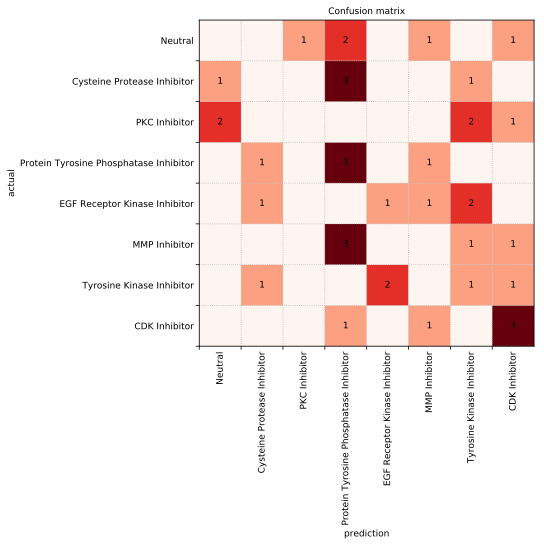

In [29]:
from src.vis_utils import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(ax, confusion, moas)

#### Multitask convolutional autoencoder

In [30]:
from src.models import multitask_conv_autoencoder

model, encoder = multitask_conv_autoencoder()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 40, 40, 3)    0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 40, 40, 3)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 40, 40, 16)   1216        input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 40, 40, 16)   64          conv2d_4[0][0]                   
          

In [31]:
nb_epochs = 10

train_gen = multi_io_generator(x_tr_s, x_tr_t, batch_size)

model_checkpoint = ModelCheckpoint('mtcae_weights.h5',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min')

hist = model.fit_generator(train_gen, steps_per_epoch=100, epochs=nb_epochs,
                           validation_data=([x_te_s, x_te_t], [x_te_s, x_te_t]),
                           callbacks=[model_checkpoint], verbose=True)

Epoch 1/10
100/100 [==============================] - 69s 687ms/step - loss: 1.7617 - main_s_loss: 0.6063 - main_t_loss: 0.6150 - val_loss: 1.3434 - val_main_s_loss: 0.4849 - val_main_t_loss: 0.4559
Epoch 2/10
100/100 [==============================] - 66s 657ms/step - loss: 1.0247 - main_s_loss: 0.3628 - main_t_loss: 0.3425 - val_loss: 1.0152 - val_main_s_loss: 0.3644 - val_main_t_loss: 0.3969
Epoch 3/10
100/100 [==============================] - 66s 659ms/step - loss: 0.8025 - main_s_loss: 0.2936 - main_t_loss: 0.2955 - val_loss: 0.8861 - val_main_s_loss: 0.3234 - val_main_t_loss: 0.3828
Epoch 4/10
100/100 [==============================] - 89s 887ms/step - loss: 0.6921 - main_s_loss: 0.2677 - main_t_loss: 0.2657 - val_loss: 0.7961 - val_main_s_loss: 0.3536 - val_main_t_loss: 0.3022
Epoch 5/10
100/100 [==============================] - 90s 896ms/step - loss: 0.6299 - main_s_loss: 0.2489 - main_t_loss: 0.2525 - val_loss: 0.7527 - val_main_s_loss: 0.3593 - val_main_t_loss: 0.2753
Epoch

In [32]:
model.load_weights('./mtcae_weights.h5')

dim_encoding = np.prod(encoder.output_shape[1:])
column_names = ['cae_%d' % i for i in range(dim_encoding)]

x_img = np.vstack([x_source, x_target])

cnn_codes = encoder.predict(x_img, verbose=True).reshape(x_img.shape[0], dim_encoding)
df_encoding = pd.DataFrame(cnn_codes, index=df_fold.index, columns=column_names)
df_encoding['well'] = df_fold.well
df_encoding = df_encoding.join(df_metadata, on='well')

18862/18862 [==============================] - 29s 2ms/step


In [33]:
df_profiles_conv = construct_profiles(df_encoding, column_names, 'adams')
_, confusion = lococv(df_profiles_conv, df_metadata, moas)
print('Accuracy: %.04f' % (np.trace(confusion) / np.sum(confusion)))

Accuracy: 0.2250


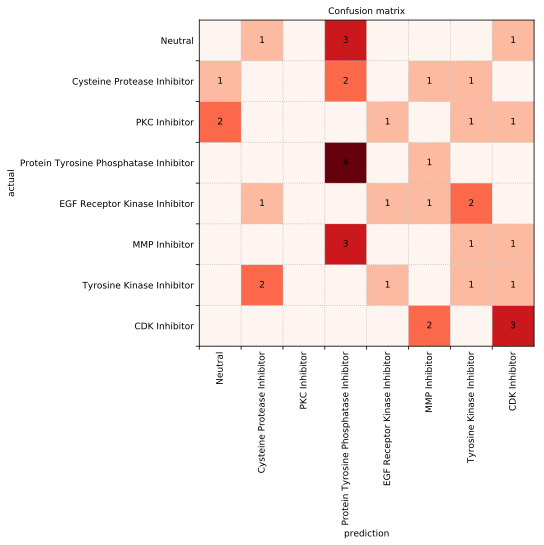

In [34]:
from src.vis_utils import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(ax, confusion, moas)

#### Domain adversarial convolutional autoencoder

In [35]:
from src.models import adversarial_conv_autoencoder

model, encoder = adversarial_conv_autoencoder(l=1e-3, lam=1.5)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 40, 40, 3)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 40, 40, 16)   1216        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 40, 40, 16)   64          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 40, 40, 16)   0           batch_normalization_15[0][0]     
__________________________________________________________________________________________________
max_poolin

In [36]:
from keras.callbacks import ModelCheckpoint
from src.utils import daae_generator

nb_epochs = 15
train_gen = daae_generator(x_tr_s, x_tr_t, batch_size)

model_checkpoint = ModelCheckpoint('dcae_weights.h5',
                                   save_best_only=True,
                                   monitor='val_main_loss',
                                   mode='min')

hist = model.fit_generator(train_gen, steps_per_epoch=100, epochs=nb_epochs,
                           validation_data=(x_val, [x_val, d_val]),
                           callbacks=[model_checkpoint], verbose=True)

Epoch 1/15
100/100 [==============================] - 110s 1s/step - loss: 4.9188 - main_loss: 0.6690 - aux_loss: 2.5724 - val_loss: 3.4764 - val_main_loss: 0.9411 - val_aux_loss: 1.4798
Epoch 2/15
100/100 [==============================] - 91s 909ms/step - loss: 1.8979 - main_loss: 0.3842 - aux_loss: 0.8418 - val_loss: 1.6168 - val_main_loss: 0.4050 - val_aux_loss: 0.6803
Epoch 3/15
100/100 [==============================] - 94s 939ms/step - loss: 1.4963 - main_loss: 0.3014 - aux_loss: 0.6956 - val_loss: 1.5418 - val_main_loss: 0.3740 - val_aux_loss: 0.6985
Epoch 4/15
100/100 [==============================] - 94s 938ms/step - loss: 1.4150 - main_loss: 0.2670 - aux_loss: 0.6978 - val_loss: 1.4536 - val_main_loss: 0.3274 - val_aux_loss: 0.6934
Epoch 5/15
100/100 [==============================] - 90s 896ms/step - loss: 1.3698 - main_loss: 0.2462 - aux_loss: 0.6977 - val_loss: 1.4229 - val_main_loss: 0.3076 - val_aux_loss: 0.6976
Epoch 6/15
100/100 [==============================] - 87s

In [37]:
model.load_weights('./dcae_weights.h5')

dim_encoding = np.prod(encoder.output_shape[1:])
column_names = ['cae_%d' % i for i in range(dim_encoding)]

x_img = np.vstack([x_source, x_target])

cnn_codes = encoder.predict(x_img, verbose=True).reshape(x_img.shape[0], dim_encoding)
df_encoding = pd.DataFrame(cnn_codes, index=df_fold.index, columns=column_names)
df_encoding['well'] = df_fold.well
df_encoding = df_encoding.join(df_metadata, on='well')

18862/18862 [==============================] - 25s 1ms/step


In [38]:
df_profiles_conv = construct_profiles(df_encoding, column_names, 'adams')
_, confusion = lococv(df_profiles_conv, df_metadata, moas)
print('Accuracy: %.04f' % (np.trace(confusion) / np.sum(confusion)))

Accuracy: 0.2750


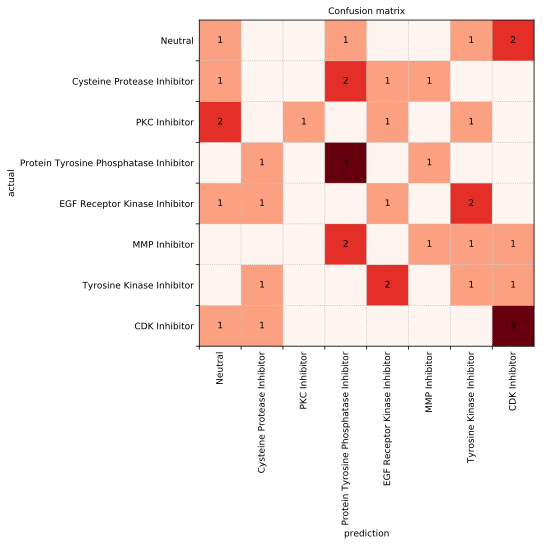

In [39]:
from src.vis_utils import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(ax, confusion, moas)